In [42]:
from math import *
import pandas as pd
import numpy as np

In [21]:
class DeviceInfo():
    def __init__(self, sm_num=0, sharedmem_per_sm=0, reg_per_sm=0, maxthreads_per_sm=0):
        self.sm_num = sm_num
        self.sharedmem_per_sm = sharedmem_per_sm # bytes
        self.reg_per_sm = reg_per_sm
        self.maxthreads_per_sm = maxthreads_per_sm
        
class KernelInfo():
    def __init__(self, blockDim=0, gridDim=0, reg_per_thread=0, sharedmem_per_blk=0, runtime_ms = 0):
        self.blockDim = blockDim
        self.gridDim = gridDim
        self.reg_per_thread = reg_per_thread
        self.sharedmem_per_blk =  sharedmem_per_blk
        self.runtime_ms = runtime_ms

In [22]:
gtx950 = DeviceInfo()
gtx950.sm_num = 6
gtx950.sharedmem_per_sm = 49152
gtx950.reg_per_sm = 65536
gtx950.maxthreads_per_sm = 2048

In [23]:
kernel = KernelInfo()
kernel.blockDim = 256
kernel.gridDim = 90
kernel.reg_per_thread = 28
kernel.sharedmem_per_blk= 0
kernel.runtime_ms = 0.057249

### compute average block execution time

In [24]:
def MaxBLK_Per_SM(Gpu, Kern):
    """
    Compute the max blocks on one SM
    """
    warp_size = 32
    DeviceLimit = Gpu.maxthreads_per_sm / 32
    
    blocks_by_sm = DeviceLimit
    
    if Kern.sharedmem_per_blk > 0:
        blocks_by_sm = floor(Gpu.sharedmem_per_sm / float(Kern.sharedmem_per_blk)) # int operation
        
    blocks_by_reg = floor(Gpu.reg_per_sm / float(Kern.reg_per_thread * Kern.blockDim))
    
    blocks_by_threads = floor(Gpu.maxthreads_per_sm / float(Kern.blockDim))
    
    # maxblks_per_sm
    return min([blocks_by_sm, blocks_by_reg, blocks_by_threads])

In [25]:
max_blk_per_sm = MaxBLK_Per_SM(gtx950, kernel)
print max_blk_per_sm

8.0


In [27]:
# max blocks that can be launhed on gpu at once time
# if there are more blocks, they will wait for the next iteration
# each SM starts and finishes at the same time
# all the blocks on that SM starts and ends at the same time
block_per_iteration = gtx950.sm_num * max_blk_per_sm

iterations = ceil(kernel.gridDim / block_per_iteration) # total iterations
print 'iterations ' + str(iterations)

# divide the kernel runtime by the number of iterations will be the avg block exeuction time for our model
avg_blk_time = kernel.runtime_ms / float(iterations)
print('avg block execution time (ms) : {}'.format(avg_blk_time))

iterations 2.0
avg block execution time (ms) : 0.0286245


### Now we model the multiple kernel concurrent execution time

In [29]:
class sm_stat:
    def __init__(self, thread=0, reg=0, sharedmem = 0, full=0, batch = 1):
        self.thread = thread
        self.reg= reg
        self.sharedmem = sharedmem
        self.full = full
        self.batch = batch

    def init(self, gtx950):
        self.thread = gtx950.maxthreads_per_sm
        self.reg = gtx950.reg_per_sm
        self.sharedmem = gtx950.sharedmem_per_sm
        self.full = 0 
        self.batch = 1
    
    def replenish(self, gtx950):
        self.thread = gtx950.maxthreads_per_sm
        self.reg = gtx950.reg_per_sm
        self.sharedmem = gtx950.sharedmem_per_sm
        self.full = 0 
        self.batch += 1 # add
        
    def allocate_block(self, Kern):
        self.thread -= Kern.blockDim
        self.reg -= Kern.reg_per_thread * Kern.blockDim
        self.sharedmem -= Kern.sharedmem_per_blk

        
def check_sm_resource(current_sm, block_info):
    enough_thread = current_sm.thread >= block_info.blockDim
    enough_reg = current_sm.reg >= (block_info.reg_per_thread * block_info.blockDim)
    enough_sm = current_sm.sharedmem >= block_info.sharedmem_per_blk
    
    allocate = 0
    if enough_thread and enough_reg and enough_sm:
        allocate = 1
    
    return allocate

In [30]:
# init SM status
sm_num = gtx950.sm_num
sms = [sm_stat() for i in range(sm_num)]

for i in range(sm_num):
    sms[i].init(gtx950)

In [32]:
print kernel.blockDim
print kernel.gridDim
print kernel.reg_per_thread
print kernel.sharedmem_per_blk
print kernel.runtime_ms

256
90
28
0
0.057249


In [33]:
# a trace table to record all the block trace: using pd dataframe
trace_table = pd.DataFrame(columns=['sm_id', 'block_id', 'block_start', 'block_end', 'batch_id', 'kernel_id'])

In [35]:
# simulate kernel number
kernel_num = 2

# note, we are running two identical one, but we can change that
kernels = [kernel for i in range(kernel_num)]

In [36]:
print kernels[0].blockDim
print kernels[1].blockDim

256
256


In [38]:
sm2start = 0

for i in range(kernel_num):
    kern = kernels[i] # schedule current kernel on the device
    kernel_blocks = int(kern.gridDim) # total block for current kern
    
    last_block_on_sm = 0
    
    #print sm2start
    
    for bid in range(kernel_blocks):
        sm_id = (bid + sm2start) % sm_num
            
        # check whether current sm has enough resources to host the block
        to_allocate_another_block = check_sm_resource(sms[sm_id], kernel)

        if to_allocate_another_block == 1:
            sms[sm_id].allocate_block(kernel)
        else:
            # consider it full, update the resources, and register in the trace table
            sms[sm_id].replenish(gtx950)
            sms[sm_id].allocate_block(kernel)
            
        # register the block in the trace table
        # note: avg blk time for current kernel
        block_end = sms[sm_id].batch * avg_blk_time
        block_start = block_end - avg_blk_time
        trace_table = trace_table.append({'sm_id': sm_id, 
                                          'block_id': bid, 
                                          'block_start': block_start,
                                          'block_end' : block_end,
                                          'batch_id': sms[sm_id].batch,
                                          'kernel_id': i}, ignore_index=True)
        last_block_on_sm = sm_id
        
    # end of running previous kernel blocks
    sm2start = last_block_on_sm

0
5


In [39]:
def run_plot_cke(df_s1, df_s2):
    import matplotlib.pyplot as plt
    
    df_s1['y_axis'] = pd.Series(np.arange(1,len(df_s1.index)+1), 
                                 index=df_s1.index)
    
    df_s2['y_axis'] = pd.Series(np.arange(1,len(df_s2.index)+1) + 0.1, 
                                 index=df_s2.index)
                                     
    x0=df_s1['block_start']
    x1=df_s1['block_end']
    y0=df_s1['y_axis']
                                
    x0_=df_s2['block_start']
    x1_=df_s2['block_end']
    y0_=df_s2['y_axis']

    ylim_max = max(df_s1['y_axis']) + 1
    axes = plt.gca()
    axes.set_ylim([0, ylim_max])

    plt.hlines(y0,x0,x1, lw=2, color='r')
    plt.hlines(y0_,x0_,x1_, lw=2, color='k')
                                
#     plt.title('Memory Bound')
    plt.xlabel('Time(clocks)')
    plt.ylabel('Blocks')
    plt.show()

In [40]:
# extract the sm-0 data
df_sm = trace_table.loc[trace_table['sm_id'] == 0]

df_kern0 = df_sm.loc[df_sm['kernel_id'] == 0]
df_kern1 = df_sm.loc[df_sm['kernel_id'] == 1]


/home/leiming/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/leiming/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


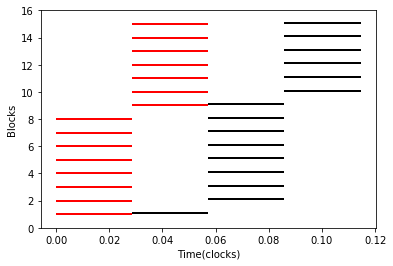

In [43]:
run_plot_cke(df_kern0, df_kern1)